In [ ]:
# Computation Analysis (setting up case_input for InputModel - connected to rain_source)

from synxflow import IO
import numpy as np
import geopandas as gpd
import os
from shapely.geometry import Point

DEM = IO.Raster("./data/DEM.gz") 
rain_mask = IO.Raster("./data/rain_mask.gz") 
rain_source = pd.read_csv("./data/rain_source.csv", header = None) 
landcover = IO.Raster("./data/landcover.gz") 

ngpus = 1
case_folder = os.path.join(os.getcwd(), 'flood_case')
case_input = IO.InputModel(DEM, num_of_sections=ngpus, case_folder=case_folder) # <class 'synxflow.IO.InputModel.InputModel'>
case_input.set_initial_condition('h0', 0.0)

box_upstream = np.array([[1427, 195],  # bottom left
                         [1446, 243]]) # upper right
box_downstream = np.array([[58, 1645], # upper left
                           [72, 1170]]) # bottom right
discharge_values = np.array([[0, 100], # first column: time - s; second colum: discharge - m3/s
                            [3600,100]])

bound_list = [
            {'polyPoints': box_upstream,
             'type': 'open',
             'hU': discharge_values},
            {'polyPoints': box_downstream,
             'type': 'open',
             'h': np.array([[0, 5],
                            [3600,5]])}] # we fix the downstream depth as 12.5 m

case_input.set_boundary_condition(boundary_list=bound_list)

rain_source_np = rain_source.to_numpy()
case_input.set_rainfall(rain_mask=rain_mask, rain_source=rain_source_np)

case_input.set_landcover(landcover)
case_input.set_grid_parameter(manning={'param_value': [0.035, 0.055],
                                        'land_value': [0, 1],
                                        'default_value':0.035})

case_input.set_gauges_position(np.array([[560, 1030],
                                        [1140,330]]))

case_input.set_runtime([0, 7200, 900, 1800])

case_input.write_input_files() # create case_folder and populate it with files

from synxflow import flood
if ngpus > 1:
    flood.run_mgpus(case_folder)
else:
    flood.run(case_folder)

case_output = IO.OutputModel(input_obj = case_input)

gauges_pos, times, values_gauge = case_output.read_gauges_file(file_tag = 'h')

max_depth = case_output.read_grid_file(file_tag='h_max_7200')

latLng = max_depth.to_points()

xv, yv = max_depth.to_points()  # Get coordinate grids
values = max_depth.array.flatten()  # Flatten raster values
points = [Point(x, y) for x, y in zip(xv.flatten(), yv.flatten())]  # Create Point geometries

gdf = gpd.GeoDataFrame({'value': values, 'geometry': points}, geometry="geometry", crs=f"EPSG:27700")

return times.tolist(), values_gauge.tolist(), gdf

In [ ]:
import pandas as pd

times = arg[0]
values = arg[1]

data = []

for i in range(len(times)):
    data.append({
        'time': times[i],
        'depth': values[i][0],
        'label': 'downstream'
    })
    data.append({
        'time': times[i],
        'depth': values[i][1],
        'label': 'upstream'
    })

df = pd.DataFrame(data)

return df

In [ ]:
# Computation Analysis (run flood and ouput)

# from synxflow import IO

# ngpus = 1
# case_folder = "./data/flood_case"

# from synxflow import flood
# if ngpus > 1:
#     flood.run_mgpus(case_folder)
# else:
#     flood.run(case_folder)

# case_output = IO.OutputModel(input_obj = case_input)

# gauges_pos, times, values = case_output.read_gauges_file(file_tag = 'h')

# return times, values

In [ ]:
# Vega-Lite (connected to Computation Analysis - line chart with times and values)

{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "description": "Depth over time for downstream and upstream",
  "width": 600,
  "height": 400,
  "mark": {
    "type": "line",
    "interpolate": "monotone"
  },
  "encoding": {
    "x": {
      "field": "time",
      "type": "quantitative",
      "title": "Time (s)"
    },
    "y": {
      "field": "depth",
      "type": "quantitative",
      "title": "Depth (m)"
    },
    "color": {
      "field": "label",
      "type": "nominal",
      "title": "Measurement",
      "scale": {
        "domain": ["downstream", "upstream"],
        "range": ["#1f77b4", "#ff7f0e"]
      }
    }
  }
}

In [ ]:
# Computation Analysis (flooding raster)

import geopandas as gpd

gdf = arg[2]

gdf = gdf.set_crs('EPSG:27700')
gdf = gdf.to_crs(3857)

gdf["geometry"] = gdf["geometry"].buffer(50)

gdf = gdf.set_geometry('geometry')

gdf = gdf.to_crs(3395)

gdf.metadata = {
    'name': 'resulting'
}

return gdf

In [ ]:
# Data transformation

# import geopandas as gpd

# max_depth = case_output.read_grid_file(file_tag='h_max_7200')

# # ========== Solution 1 ================
# # src_epsg=27700 #EPSG code of the coordinate reference system of the original dataset, default is 27700 for BNG

# # if not hasattr(max_depth, 'meta'):
# #     max_depth.get_meta(src_epsg)

# # meta = max_depth.meta  # dictionary
# # array_data = max_depth.array.copy()  # Ensure a copy to avoid modifying the original
# # nomask = np.isnan(array_data)
# # array_data[nomask] = meta['nodata']
# # ======================================

# latLng = max_depth.to_points()

# xv, yv = max_depth.to_points()  # Get coordinate grids
# values = max_depth.array.flatten()  # Flatten raster values
# points = [Point(x, y) for x, y in zip(xv.flatten(), yv.flatten())]  # Create Point geometries

# gdf = gpd.GeoDataFrame({'value': values, 'geometry': points}, crs=f"EPSG:27700")

# return gdf

# # gdf.plot(column="value", cmap="plasma", legend=True, markersize=10)

# # .get_summary() - Get information summary of the object
# # .set_crs()
# # .to_points() - Get X and Y coordinates of all raster cells
# # .write_asc(output_file) - Write raster as asc format file
# # .write() - Export to a file, tif, asc, txt, or gz
# # .write_tif() - Convert to a resterio dataset


In [ ]:
# load box
import utk

uc = utk.OSM.load([42.336844, -71.113459, 42.345559, -71.099216], layers=[{'name':'buildings', 'args': {'sizeCells': 5}}, {'name':'surface', 'args': {'sizeCells': 5}}, 'parks'])

# buildings
gdf_buildings = uc.layers['gdf']['sections'][0]
gdf_buildings['thematic'] = 0.5
gdf_buildings.metadata = {
 'name': 'buildings'
}

#surface
json_surface = uc.layers['json'][1]
gdf_surface = uc.layers['gdf']['objects'][1]
gdf_surface.metadata = {
 'name': 'surface'
}

#parks
json_parks = uc.layers['json'][2]
gdf_parks = uc.layers['gdf']['objects'][2]
gdf_parks.metadata = {
 'name': 'parks'
}

return gdf_buildings, gdf_surface, gdf_parks

c:\Users\Gustavo\miniforge3\envs\sandbox-curio\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


********************************************************************************
PlotOptiX newer version is available: 0.18.4
to update your release use:
      pip install plotoptix --upgrade
********************************************************************************


c:\Users\Gustavo\miniforge3\envs\sandbox-curio\lib\site-packages\geopandas\geodataframe.py:205: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


c:\Users\Gustavo\miniforge3\envs\sandbox-curio\lib\site-packages\geopandas\geodataframe.py:205: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


<Axes: >

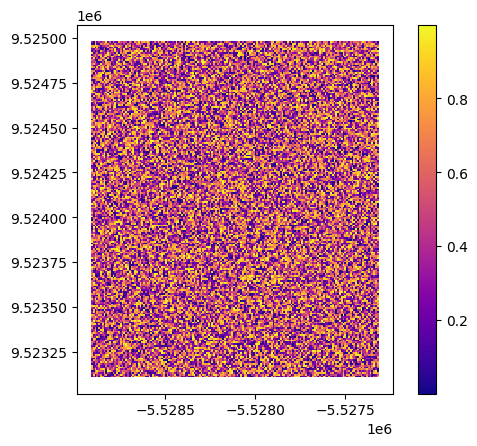

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

minx, miny, maxx, maxy = gdf_surface.geometry.total_bounds
cell_size = 10

grid_cells = []
for x0 in np.arange(minx, maxx, cell_size):
    for y0 in np.arange(miny, maxy, cell_size):
        # 1st cell boundary
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        grid_cells.append(Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]))

grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3395")

grid_gdf = grid_gdf.reset_index(drop=True)

grid_gdf['value'] = np.random.rand(len(grid_gdf))

grid_gdf.metadata = {
    'name': 'grid'
}

return grid_gdf

In [ ]:
# Spatial aggregation of grid_gdf and gdf (flooding raster)